In [1]:
%pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 12.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
%pip install git+https://github.com/boudinfl/pke.git
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-uz9i9ktd
  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git /tmp/pip-req-build-uz9i9ktd
  Resolved https://github.com/boudinfl/pke.git to commit f2d4f5d2252c64d23defccd32fdac8809cfd7ce0
  Preparing metadata (setup.py) ... done
2023-04-16 13:50:08.535184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 13:50:12.026385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [114]:
keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']
sample = ds['train'][13]
input_words = [sample['kanji_meaning']] + sample['component_meanings'].split(',')
input_words

['distribute', 'alcohol', 'oneself']

In [115]:
sample[keys[1]]

'Once upon a time there was a young man who was struggling with his alcohol consumption. He knew that he had to take control of himself and his drinking, so he decided to distribute his alcohol into smaller portions. This way, he could limit himself and still enjoy his drinks. He was successful in achieving his goal and was able to stay in control of himself and his alcohol consumption.'

In [64]:
import pke
import string
import re

stoplist = list(string.punctuation)
stoplist += pke.lang.stopwords.get('en')

def topic_rank_extract(text):
    text = re.sub(r'<.*?>', '', text)
    topic_rank = pke.unsupervised.TopicRank()
    topic_rank.load_document(input=text, language='en', stoplist=stoplist)
    pos = {'NOUN', 'PROPN', 'ADJ', 'VERB'}
    topic_rank.candidate_selection(pos=pos)
    topic_rank.candidate_weighting()
    return topic_rank.get_n_best(n=10)

In [103]:
def multi_partite_rank_extract(text):
    text = re.sub(r'<.*?>', '', text)
    multi_partite_rank = pke.unsupervised.MultipartiteRank()
    multi_partite_rank.load_document(input=text, language='en', stoplist=stoplist)
    pos = {'NOUN', 'PROPN', 'ADJ', 'VERB'}
    multi_partite_rank.candidate_selection(pos=pos)
    multi_partite_rank.candidate_weighting()
    return multi_partite_rank.get_n_best(n=10)

In [127]:
def yake_extract(text):
    text = re.sub(r'<.*?>', '', text)
    yake = pke.unsupervised.YAKE()
    yake.load_document(input=text, language='en', stoplist=stoplist)
    yake.candidate_selection(n=3)
    yake.candidate_weighting()
    return yake.get_n_best(n=10)

In [167]:
df_file = '/usr/local/lib/python3.9/dist-packages/pke/models/df-semeval2010.tsv.gz'
df = pke.utils.load_document_frequency_file(input_file=df_file)

def kp_miner_extract(text):
    text = re.sub(r'<.*?>', '', text)
    kp_miner = pke.unsupervised.KPMiner()
    kp_miner.load_document(input=text, language='en')
    kp_miner.candidate_selection(lasf=1)
    kp_miner.candidate_weighting(df=df)
    return kp_miner.get_n_best(n=10)

In [65]:
import nltk
stemmer = nltk.stem.PorterStemmer()

def any_in(keyphrase, input_words):
    input_stems = set([stemmer.stem(word) for word in input_words])
    keyphrase_stems = set([stemmer.stem(word) for word in keyphrase.split()])

    return len(input_stems & keyphrase_stems) > 0 

In [98]:
import numpy as np

def centrality_score(text, input_words, extract_fn):
    keywords = extract_fn(text)
    total_score = 0
    for _, score in keywords:
        total_score += score
    
    mask = [(any_in(keyphrase, input_words), score / total_score) for keyphrase, score in keywords]
    assert(np.isclose(np.sum([score for _, score in mask]), 1))

    return np.sum([score for in_input, score in mask if in_input])


In [99]:
def map_centralities(extract_fn):
    def inner(example):
        input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
        for key in keys:
            example[key + '_centrality'] = centrality_score(example[key], input_words, extract_fn)
        return example
    return inner

In [92]:
ds_topic_rank = ds.map(map_centralities)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [83]:
from scipy.stats import f_oneway
def anova(ds):
    f, p = f_oneway(*[ds[key+'_centrality'] for key in keys])
    return f, p

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def box_plot(ds,title, labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani']):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.boxplot([ds[key+'_centrality'] for key in keys], labels=labels)
    plt.show()

In [85]:
from scipy.stats import tukey_hsd

def tukey(ds):
    data = [ds[key+'_centrality'] for key in keys]
    res = tukey_hsd(*data)
    print(res)

In [132]:
def mean_std(ds):
    return [(key, np.mean(ds[key+'_centrality']), np.std(ds[key+'_centrality'])) for key in keys]

In [133]:
mean_std(ds_topic_rank['train'])

[('gpt2xl_mnemonic', 0.14501320120608316, 0.10508290665706825),
 ('gpt3_mnemonic', 0.3327725101151016, 0.12752535535468412),
 ('gpt3_paragraph', 0.3022841502581947, 0.1334194356861939),
 ('wanikani_mnemonic', 0.4242303781347497, 0.14453778876912093)]

In [93]:
print(anova(ds_topic_rank['train']))

(154.75295917717926, 3.4285253847096814e-78)


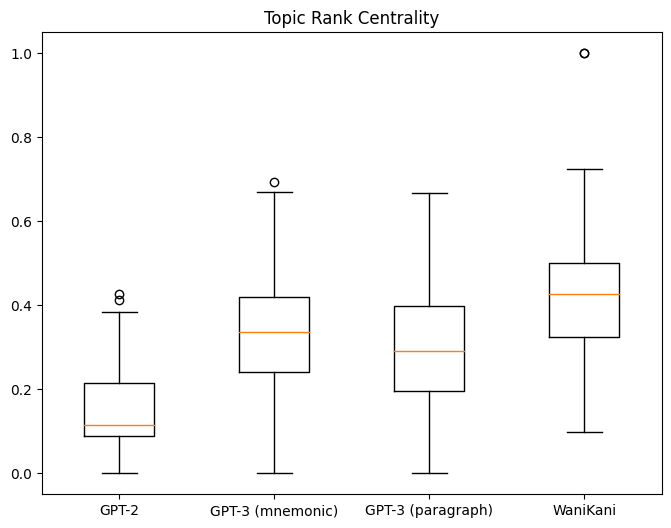

In [94]:
box_plot(ds_topic_rank['train'], 'Topic Rank Centrality')

In [95]:
tukey(ds_topic_rank['train'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.188     0.000    -0.222    -0.154
 (0 - 2)     -0.157     0.000    -0.191    -0.123
 (0 - 3)     -0.279     0.000    -0.313    -0.245
 (1 - 0)      0.188     0.000     0.154     0.222
 (1 - 2)      0.030     0.097    -0.004     0.065
 (1 - 3)     -0.091     0.000    -0.125    -0.057
 (2 - 0)      0.157     0.000     0.123     0.191
 (2 - 1)     -0.030     0.097    -0.065     0.004
 (2 - 3)     -0.122     0.000    -0.156    -0.088
 (3 - 0)      0.279     0.000     0.245     0.313
 (3 - 1)      0.091     0.000     0.057     0.125
 (3 - 2)      0.122     0.000     0.088     0.156



In [129]:
ds_yake = ds.map(map_centralities(yake_extract))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [130]:
print(anova(ds_yake['train']))

(25.959795492217754, 5.450854412388377e-16)


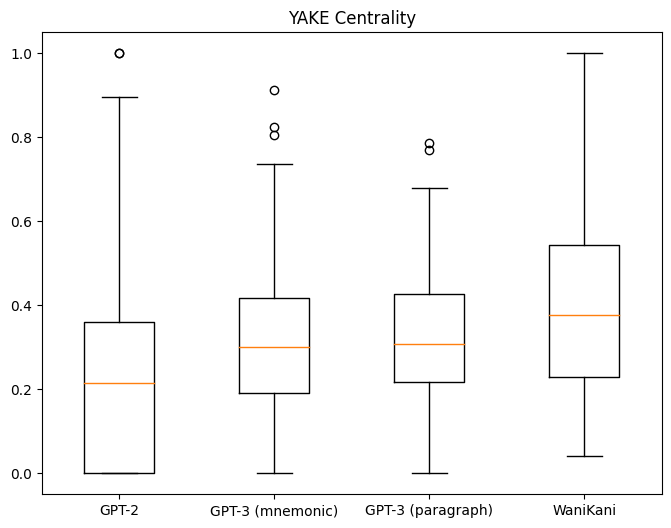

In [131]:
box_plot(ds_yake['train'], 'YAKE Centrality')

In [134]:
mean_std(ds_yake['train'])

[('gpt2xl_mnemonic', 0.2323870936096025, 0.22131229706601413),
 ('gpt3_mnemonic', 0.31204276056740465, 0.17702300917406658),
 ('gpt3_paragraph', 0.32194739034093195, 0.148086948038689),
 ('wanikani_mnemonic', 0.4044564588343753, 0.2048325694792195)]

In [145]:
ds_multi_partite_rank = ds.map(map_centralities(multi_partite_rank_extract))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [146]:
mean_std(ds_multi_partite_rank['train'])

[('gpt2xl_mnemonic', 0.1502600076748947, 0.11150725038188475),
 ('gpt3_mnemonic', 0.35336190441593507, 0.1410850925746548),
 ('gpt3_paragraph', 0.3139196557952057, 0.13616862562980028),
 ('wanikani_mnemonic', 0.46683374838869873, 0.15341301256340803)]

In [147]:
print(anova(ds_multi_partite_rank['train']))

(174.4548578248015, 6.1058651268029676e-86)


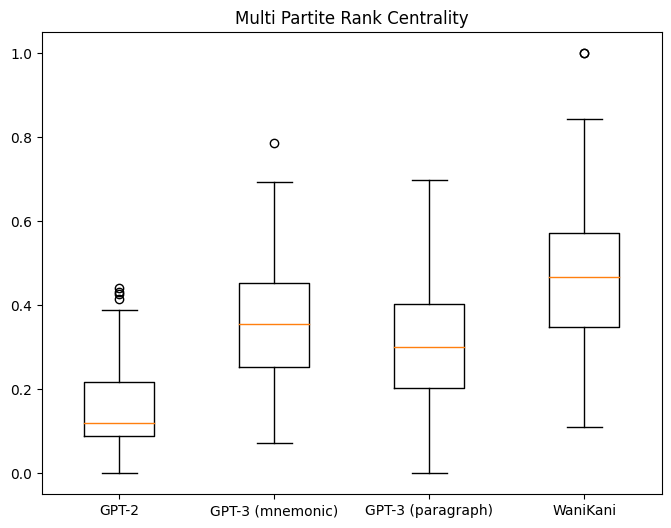

In [148]:
box_plot(ds_multi_partite_rank['train'], 'Multi Partite Rank Centrality')

In [149]:
tukey(ds_multi_partite_rank['train'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.203     0.000    -0.239    -0.167
 (0 - 2)     -0.164     0.000    -0.200    -0.128
 (0 - 3)     -0.317     0.000    -0.353    -0.280
 (1 - 0)      0.203     0.000     0.167     0.239
 (1 - 2)      0.039     0.026     0.003     0.076
 (1 - 3)     -0.113     0.000    -0.150    -0.077
 (2 - 0)      0.164     0.000     0.128     0.200
 (2 - 1)     -0.039     0.026    -0.076    -0.003
 (2 - 3)     -0.153     0.000    -0.189    -0.117
 (3 - 0)      0.317     0.000     0.280     0.353
 (3 - 1)      0.113     0.000     0.077     0.150
 (3 - 2)      0.153     0.000     0.117     0.189



In [169]:
ds_kp_miner = ds.map(map_centralities(kp_miner_extract))

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [174]:
mean_std(ds_kp_miner['train'])

[('gpt2xl_mnemonic', 0.3056675410615038, 0.22539893911277337),
 ('gpt3_mnemonic', 0.42396146461608497, 0.21788980656045587),
 ('gpt3_paragraph', 0.4226580082103133, 0.20984981634989988),
 ('wanikani_mnemonic', 0.5682201229098697, 0.2160959197459552)]

In [171]:
print(anova(ds_kp_miner['train']))

(46.20121266216916, 2.0167160121159935e-27)


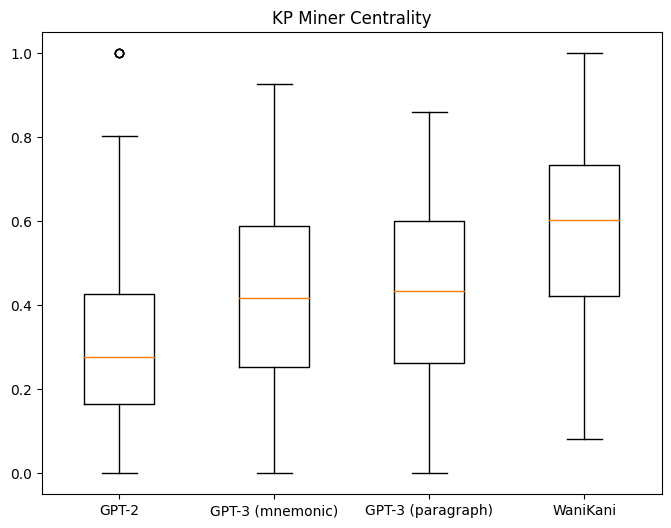

In [172]:
box_plot(ds_kp_miner['train'], 'KP Miner Centrality')

In [173]:
tukey(ds_kp_miner['train'])

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.118     0.000    -0.176    -0.061
 (0 - 2)     -0.117     0.000    -0.175    -0.059
 (0 - 3)     -0.263     0.000    -0.320    -0.205
 (1 - 0)      0.118     0.000     0.061     0.176
 (1 - 2)      0.001     1.000    -0.056     0.059
 (1 - 3)     -0.144     0.000    -0.202    -0.087
 (2 - 0)      0.117     0.000     0.059     0.175
 (2 - 1)     -0.001     1.000    -0.059     0.056
 (2 - 3)     -0.146     0.000    -0.203    -0.088
 (3 - 0)      0.263     0.000     0.205     0.320
 (3 - 1)      0.144     0.000     0.087     0.202
 (3 - 2)      0.146     0.000     0.088     0.203

